In [54]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from dataset import WeaponsDataset
import math

In [2]:
# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
# hyper parameters
num_epochs = 100
batch_size = 20
learning_rate = 1e-4
latent_dim = 100

In [4]:
# Load and normalize Weapon dataset to [-1, 1]

weapons_train_dataset = WeaponsDataset()

weapons_train_loader = DataLoader(weapons_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

/home/ulascanzorer/Desktop/DarkSoulsWeaponGenerator/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([4, 64, 64])


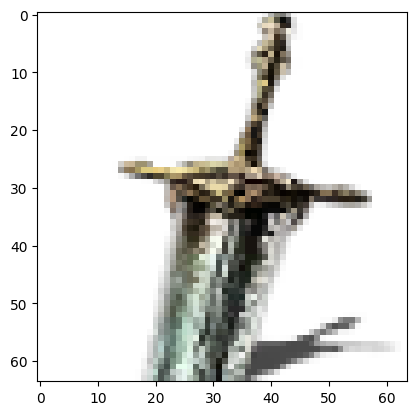

In [5]:
# Weapon example

# Display one image as an example
dataiter = iter(weapons_train_loader)
images = next(dataiter)
print(images[0].shape)
first_image = np.transpose(images[0], (1, 2, 0))
first_image = first_image / 2 + 0.5     # unnormalize

plt.imshow(first_image)
plt.show()

In [6]:
# Define the discriminator, returns a value between 0 and 1, a possibility.
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )
        

    def forward(self, x):
        output = self.model(x)
        return output.view(-1, 1).squeeze(1)

In [8]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 4, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)

In [26]:
# Create the generator, the discriminator and their respective optimizers.
generator = Generator().to(device)

discriminator = Discriminator().to(device)

genopt = torch.optim.Adam(generator.parameters(), lr=learning_rate)

discopt = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

criterion = nn.BCELoss()

In [27]:
def train_models():
    real_label = 1.0
    fake_label = 0.0

    # Training the models
    n_total_steps = len(weapons_train_loader)
    for epoch in range(num_epochs):
        for i, real in enumerate(weapons_train_loader):
            ### Train the discriminator: max log(D(x)) + log(1 - D(G(z))) ###

            # train with real images
            real = real.to(device)
            current_batch_size = real.shape[0]
            label1 = torch.full((current_batch_size, ), real_label, device=device)

            output_real = discriminator(real)
            real_error_d = criterion(output_real, label1)

            # train with fake images
            z = torch.randn(current_batch_size, latent_dim, 1, 1, device=device)
            fake = generator(z)
            label2 = torch.full((current_batch_size, ), fake_label, device=device)
            output_fake = discriminator(fake.detach())
            fake_error_d = criterion(output_fake, label2)
            err_d = (real_error_d + fake_error_d)

            discopt.zero_grad()
            err_d.backward()
            discopt.step()

            ### Train the generator: max log(D(G(z))) ###

            label3 = torch.full((current_batch_size, ), real_label, device=device) # fake labels become real labels for the generator to maximize the equation
            output_fake_2 = discriminator(fake)
            err_g = criterion(output_fake_2, label3)

            genopt.zero_grad()
            err_g.backward()
            genopt.step()


            if (i + 1) % 10 == 0:
                print(f'epoch {epoch + 1} / {num_epochs}, step {i + 1} / {n_total_steps}, gen_loss = {err_g.item():.4f}, disc_loss = {err_d.item():.4f}')
            

        if epoch % 5 == 0:
            # Sample an image from the generator
            discriminator.eval()    # Disable dropout and such
            generator.eval()

            z1 = (torch.randn(1, latent_dim, 1, 1)).to(device)

            image = generator(z1)[0].cpu().view(1, 4, 64, 64)
            print(image.shape)

            discriminator_output = discriminator(image.to(device))
            print(discriminator_output)

            # Display one image as an example (CIFAR)
            image = np.transpose(image.view(4, 64, 64).detach(), (1, 2, 0))
            image = image / 2 + 0.5    # unnormalize

            plt.imshow(image)
            plt.show()

            discriminator.train()
            generator.train()

epoch 1 / 100, step 10 / 11, gen_loss = 0.0000, disc_loss = 100.0000
torch.Size([1, 4, 64, 64])
tensor([1.], device='cuda:0', grad_fn=<SqueezeBackward1>)


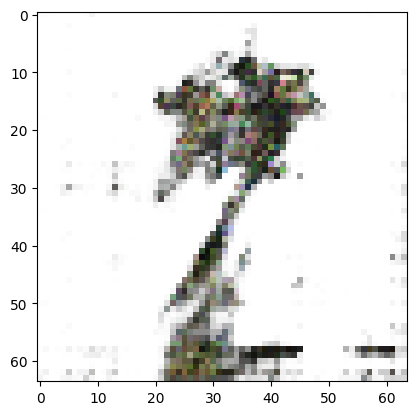

epoch 2 / 100, step 10 / 11, gen_loss = 8.7777, disc_loss = 0.0939
epoch 3 / 100, step 10 / 11, gen_loss = 3.9571, disc_loss = 0.0433
epoch 4 / 100, step 10 / 11, gen_loss = 5.7083, disc_loss = 0.2120
epoch 5 / 100, step 10 / 11, gen_loss = 6.8987, disc_loss = 0.1144
epoch 6 / 100, step 10 / 11, gen_loss = 6.4535, disc_loss = 0.0260
torch.Size([1, 4, 64, 64])
tensor([0.1761], device='cuda:0', grad_fn=<SqueezeBackward1>)


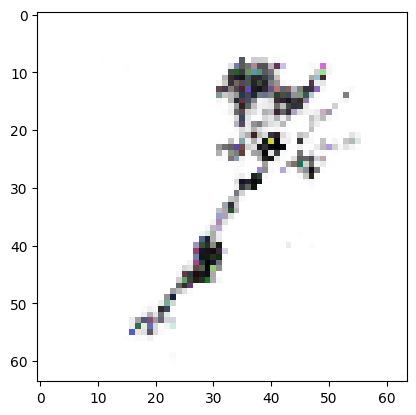

epoch 7 / 100, step 10 / 11, gen_loss = 6.1166, disc_loss = 0.1348
epoch 8 / 100, step 10 / 11, gen_loss = 6.4454, disc_loss = 0.0245
epoch 9 / 100, step 10 / 11, gen_loss = 9.7123, disc_loss = 0.0083
epoch 10 / 100, step 10 / 11, gen_loss = 8.9953, disc_loss = 0.0496
epoch 11 / 100, step 10 / 11, gen_loss = 7.0568, disc_loss = 0.1789
torch.Size([1, 4, 64, 64])
tensor([0.0004], device='cuda:0', grad_fn=<SqueezeBackward1>)


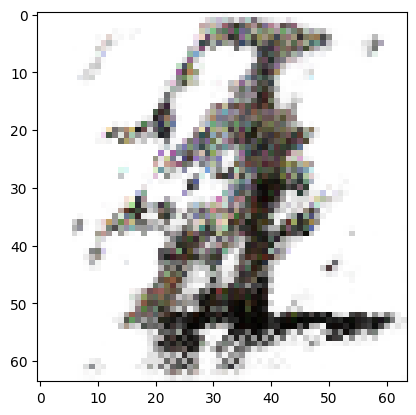

epoch 12 / 100, step 10 / 11, gen_loss = 5.7702, disc_loss = 0.0653
epoch 13 / 100, step 10 / 11, gen_loss = 6.4137, disc_loss = 0.1413
epoch 14 / 100, step 10 / 11, gen_loss = 6.7260, disc_loss = 0.0479
epoch 15 / 100, step 10 / 11, gen_loss = 5.0883, disc_loss = 0.1806
epoch 16 / 100, step 10 / 11, gen_loss = 5.0518, disc_loss = 0.0694
torch.Size([1, 4, 64, 64])
tensor([0.0385], device='cuda:0', grad_fn=<SqueezeBackward1>)


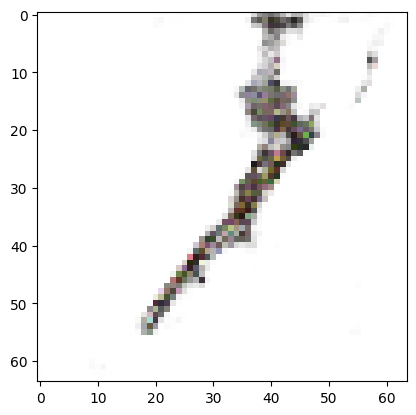

epoch 17 / 100, step 10 / 11, gen_loss = 7.1554, disc_loss = 0.0824
epoch 18 / 100, step 10 / 11, gen_loss = 7.8516, disc_loss = 0.0679
epoch 19 / 100, step 10 / 11, gen_loss = 7.3818, disc_loss = 0.1755
epoch 20 / 100, step 10 / 11, gen_loss = 8.2331, disc_loss = 0.0196
epoch 21 / 100, step 10 / 11, gen_loss = 11.5134, disc_loss = 0.1792
torch.Size([1, 4, 64, 64])
tensor([0.0084], device='cuda:0', grad_fn=<SqueezeBackward1>)


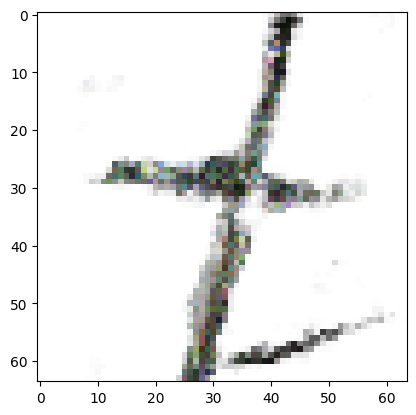

epoch 22 / 100, step 10 / 11, gen_loss = 11.0136, disc_loss = 0.1889
epoch 23 / 100, step 10 / 11, gen_loss = 14.5228, disc_loss = 0.3548
epoch 24 / 100, step 10 / 11, gen_loss = 5.5335, disc_loss = 0.0963
epoch 25 / 100, step 10 / 11, gen_loss = 6.1247, disc_loss = 0.3467
epoch 26 / 100, step 10 / 11, gen_loss = 7.5020, disc_loss = 0.0609
torch.Size([1, 4, 64, 64])
tensor([0.0004], device='cuda:0', grad_fn=<SqueezeBackward1>)


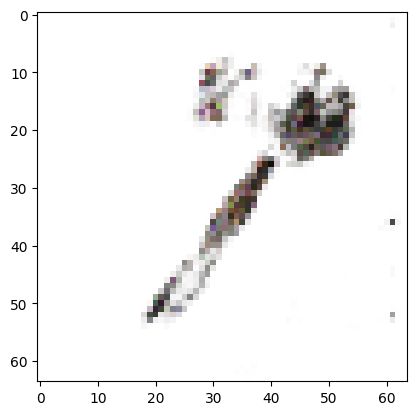

epoch 27 / 100, step 10 / 11, gen_loss = 7.1393, disc_loss = 0.0427
epoch 28 / 100, step 10 / 11, gen_loss = 11.1802, disc_loss = 0.2302
epoch 29 / 100, step 10 / 11, gen_loss = 10.5762, disc_loss = 0.0005
epoch 30 / 100, step 10 / 11, gen_loss = 7.7749, disc_loss = 0.0432
epoch 31 / 100, step 10 / 11, gen_loss = 6.5649, disc_loss = 0.1387
torch.Size([1, 4, 64, 64])
tensor([0.9534], device='cuda:0', grad_fn=<SqueezeBackward1>)


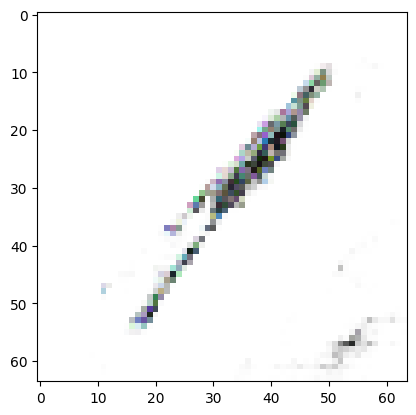

epoch 32 / 100, step 10 / 11, gen_loss = 5.6492, disc_loss = 0.0619
epoch 33 / 100, step 10 / 11, gen_loss = 13.1331, disc_loss = 0.0665
epoch 34 / 100, step 10 / 11, gen_loss = 11.2050, disc_loss = 0.0012
epoch 35 / 100, step 10 / 11, gen_loss = 5.0973, disc_loss = 0.1282
epoch 36 / 100, step 10 / 11, gen_loss = 6.6130, disc_loss = 0.1248
torch.Size([1, 4, 64, 64])
tensor([0.9397], device='cuda:0', grad_fn=<SqueezeBackward1>)


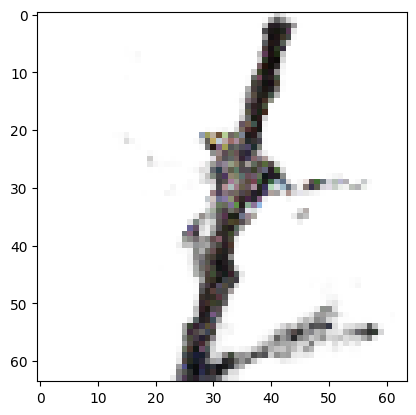

epoch 37 / 100, step 10 / 11, gen_loss = 6.3403, disc_loss = 0.0239
epoch 38 / 100, step 10 / 11, gen_loss = 8.2811, disc_loss = 0.0180
epoch 39 / 100, step 10 / 11, gen_loss = 6.0146, disc_loss = 0.1456
epoch 40 / 100, step 10 / 11, gen_loss = 10.7455, disc_loss = 0.1106
epoch 41 / 100, step 10 / 11, gen_loss = 7.6067, disc_loss = 0.0173
torch.Size([1, 4, 64, 64])
tensor([0.0213], device='cuda:0', grad_fn=<SqueezeBackward1>)


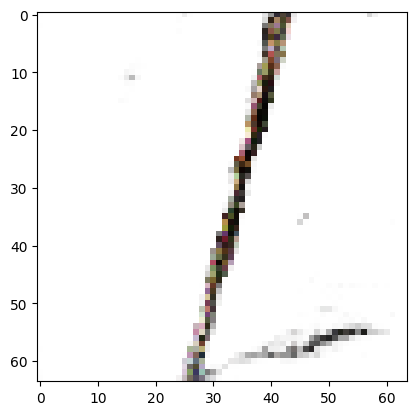

epoch 42 / 100, step 10 / 11, gen_loss = 7.1241, disc_loss = 0.0908
epoch 43 / 100, step 10 / 11, gen_loss = 5.3745, disc_loss = 0.1479
epoch 44 / 100, step 10 / 11, gen_loss = 11.0060, disc_loss = 0.4616
epoch 45 / 100, step 10 / 11, gen_loss = 14.7017, disc_loss = 0.0400
epoch 46 / 100, step 10 / 11, gen_loss = 7.1268, disc_loss = 0.0135
torch.Size([1, 4, 64, 64])
tensor([0.0684], device='cuda:0', grad_fn=<SqueezeBackward1>)


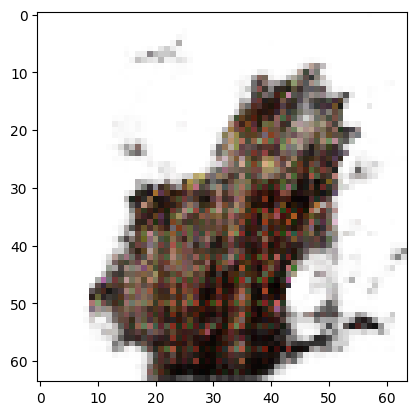

epoch 47 / 100, step 10 / 11, gen_loss = 7.4181, disc_loss = 0.8142
epoch 48 / 100, step 10 / 11, gen_loss = 7.8679, disc_loss = 0.0474
epoch 49 / 100, step 10 / 11, gen_loss = 5.4727, disc_loss = 0.0129
epoch 50 / 100, step 10 / 11, gen_loss = 7.5268, disc_loss = 0.0595
epoch 51 / 100, step 10 / 11, gen_loss = 4.3379, disc_loss = 0.1761
torch.Size([1, 4, 64, 64])
tensor([0.1525], device='cuda:0', grad_fn=<SqueezeBackward1>)


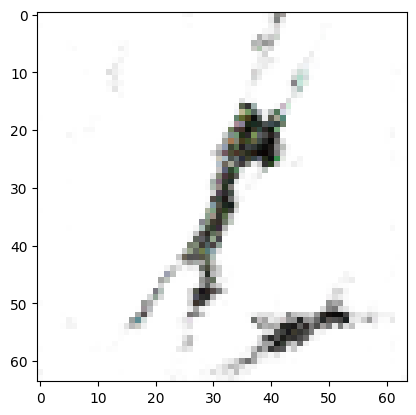

epoch 52 / 100, step 10 / 11, gen_loss = 6.1349, disc_loss = 0.0217
epoch 53 / 100, step 10 / 11, gen_loss = 6.1133, disc_loss = 0.0181
epoch 54 / 100, step 10 / 11, gen_loss = 6.7507, disc_loss = 0.0406
epoch 55 / 100, step 10 / 11, gen_loss = 9.8733, disc_loss = 0.4923
epoch 56 / 100, step 10 / 11, gen_loss = 4.6981, disc_loss = 0.0356
torch.Size([1, 4, 64, 64])
tensor([0.6576], device='cuda:0', grad_fn=<SqueezeBackward1>)


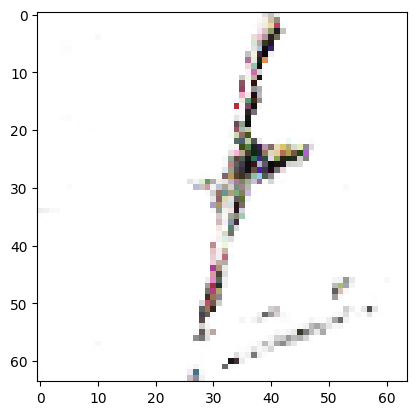

epoch 57 / 100, step 10 / 11, gen_loss = 6.3586, disc_loss = 0.0126
epoch 58 / 100, step 10 / 11, gen_loss = 3.9406, disc_loss = 0.0277
epoch 59 / 100, step 10 / 11, gen_loss = 6.4477, disc_loss = 0.0074
epoch 60 / 100, step 10 / 11, gen_loss = 7.4189, disc_loss = 0.0035
epoch 61 / 100, step 10 / 11, gen_loss = 5.9406, disc_loss = 0.0681
torch.Size([1, 4, 64, 64])
tensor([0.0121], device='cuda:0', grad_fn=<SqueezeBackward1>)


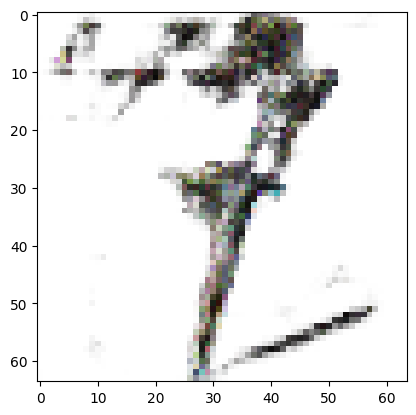

epoch 62 / 100, step 10 / 11, gen_loss = 7.5703, disc_loss = 0.0344
epoch 63 / 100, step 10 / 11, gen_loss = 6.1381, disc_loss = 0.0515
epoch 64 / 100, step 10 / 11, gen_loss = 7.0912, disc_loss = 0.0076
epoch 65 / 100, step 10 / 11, gen_loss = 8.8921, disc_loss = 0.0943
epoch 66 / 100, step 10 / 11, gen_loss = 6.2048, disc_loss = 0.1148
torch.Size([1, 4, 64, 64])
tensor([0.6190], device='cuda:0', grad_fn=<SqueezeBackward1>)


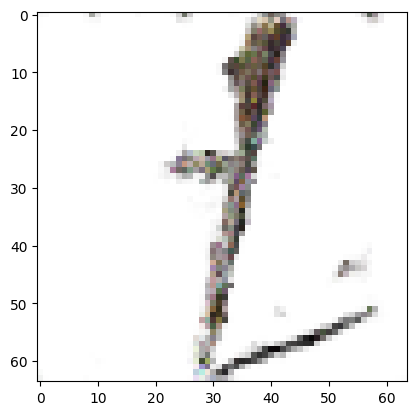

epoch 67 / 100, step 10 / 11, gen_loss = 8.8302, disc_loss = 0.0614
epoch 68 / 100, step 10 / 11, gen_loss = 8.5641, disc_loss = 0.0322
epoch 69 / 100, step 10 / 11, gen_loss = 7.8299, disc_loss = 0.0041
epoch 70 / 100, step 10 / 11, gen_loss = 2.3412, disc_loss = 0.1917
epoch 71 / 100, step 10 / 11, gen_loss = 8.5305, disc_loss = 0.0047
torch.Size([1, 4, 64, 64])
tensor([0.0158], device='cuda:0', grad_fn=<SqueezeBackward1>)


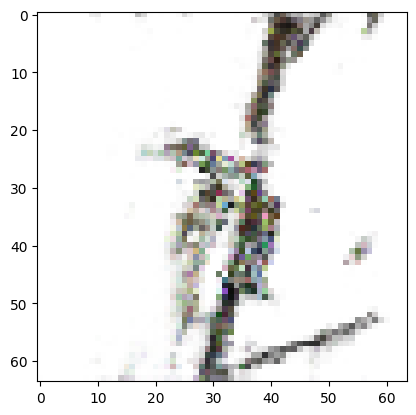

epoch 72 / 100, step 10 / 11, gen_loss = 17.7067, disc_loss = 0.0139
epoch 73 / 100, step 10 / 11, gen_loss = 8.6176, disc_loss = 0.0119
epoch 74 / 100, step 10 / 11, gen_loss = 9.3280, disc_loss = 0.1141
epoch 75 / 100, step 10 / 11, gen_loss = 6.8738, disc_loss = 0.1121
epoch 76 / 100, step 10 / 11, gen_loss = 5.3291, disc_loss = 0.1099
torch.Size([1, 4, 64, 64])
tensor([0.0733], device='cuda:0', grad_fn=<SqueezeBackward1>)


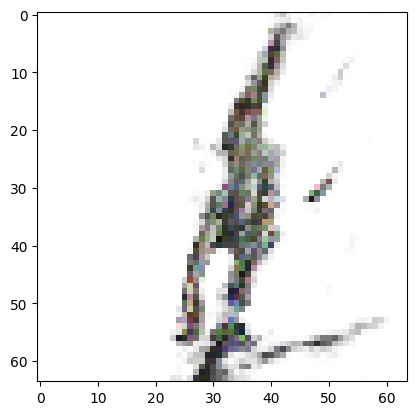

epoch 77 / 100, step 10 / 11, gen_loss = 5.4620, disc_loss = 0.0242
epoch 78 / 100, step 10 / 11, gen_loss = 6.2890, disc_loss = 0.0103
epoch 79 / 100, step 10 / 11, gen_loss = 24.0128, disc_loss = 0.0872
epoch 80 / 100, step 10 / 11, gen_loss = 9.8782, disc_loss = 0.0678
epoch 81 / 100, step 10 / 11, gen_loss = 6.0946, disc_loss = 0.3473
torch.Size([1, 4, 64, 64])
tensor([0.0020], device='cuda:0', grad_fn=<SqueezeBackward1>)


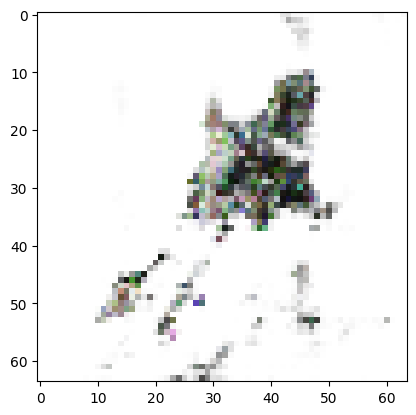

epoch 82 / 100, step 10 / 11, gen_loss = 5.4542, disc_loss = 0.7837
epoch 83 / 100, step 10 / 11, gen_loss = 7.4164, disc_loss = 0.0141
epoch 84 / 100, step 10 / 11, gen_loss = 16.2186, disc_loss = 0.4626
epoch 85 / 100, step 10 / 11, gen_loss = 5.3910, disc_loss = 0.0272
epoch 86 / 100, step 10 / 11, gen_loss = 4.8288, disc_loss = 0.0461
torch.Size([1, 4, 64, 64])
tensor([0.1139], device='cuda:0', grad_fn=<SqueezeBackward1>)


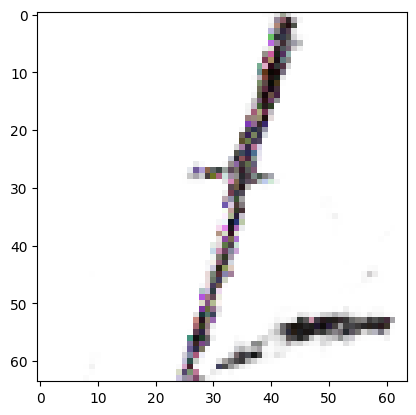

epoch 87 / 100, step 10 / 11, gen_loss = 6.7441, disc_loss = 0.0346
epoch 88 / 100, step 10 / 11, gen_loss = 5.9667, disc_loss = 0.0296
epoch 89 / 100, step 10 / 11, gen_loss = 3.8742, disc_loss = 0.0882
epoch 90 / 100, step 10 / 11, gen_loss = 6.0039, disc_loss = 0.0182
epoch 91 / 100, step 10 / 11, gen_loss = 7.1357, disc_loss = 0.0185
torch.Size([1, 4, 64, 64])
tensor([0.0191], device='cuda:0', grad_fn=<SqueezeBackward1>)


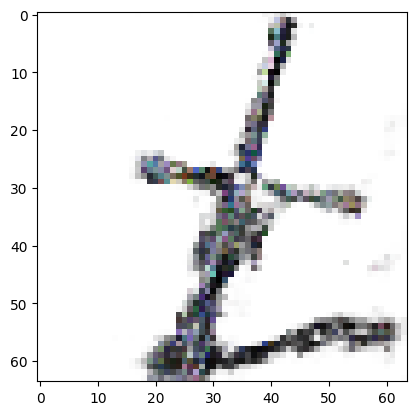

epoch 92 / 100, step 10 / 11, gen_loss = 5.6766, disc_loss = 0.0190
epoch 93 / 100, step 10 / 11, gen_loss = 5.6451, disc_loss = 0.0235
epoch 94 / 100, step 10 / 11, gen_loss = 7.4944, disc_loss = 0.0565
epoch 95 / 100, step 10 / 11, gen_loss = 6.8535, disc_loss = 0.0046
epoch 96 / 100, step 10 / 11, gen_loss = 4.4187, disc_loss = 0.1379
torch.Size([1, 4, 64, 64])
tensor([0.9966], device='cuda:0', grad_fn=<SqueezeBackward1>)


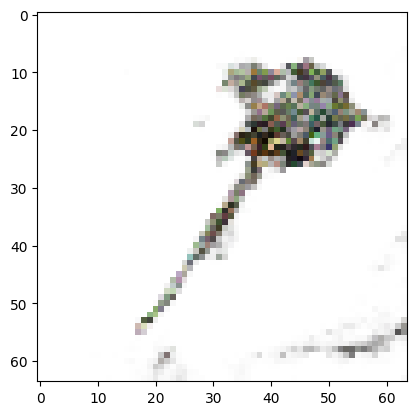

epoch 97 / 100, step 10 / 11, gen_loss = 5.7122, disc_loss = 0.0999
epoch 98 / 100, step 10 / 11, gen_loss = 5.9402, disc_loss = 0.0090
epoch 99 / 100, step 10 / 11, gen_loss = 2.9707, disc_loss = 0.1971
epoch 100 / 100, step 10 / 11, gen_loss = 8.1462, disc_loss = 0.7297


In [45]:
train_models()

torch.Size([1, 4, 64, 64])
tensor([0.1671], device='cuda:0', grad_fn=<SqueezeBackward1>)


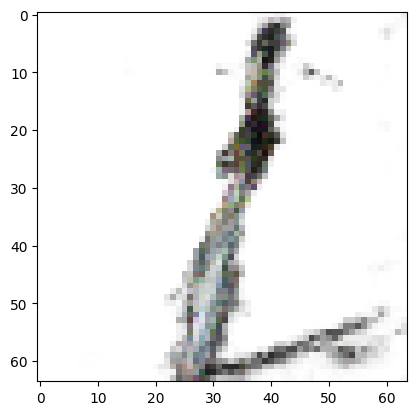

In [52]:
# Sample an image from the generator
discriminator.eval()    # Disable dropout and such
generator.eval()

z1 = (torch.randn(1, latent_dim, 1, 1)).to(device)

image = generator(z1)[0].cpu().view(1, 4, 64, 64)
print(image.shape)

discriminator_output = discriminator(image.to(device))
print(discriminator_output)

# Display one image as an example (CIFAR)
image = np.transpose(image.view(4, 64, 64).detach(), (1, 2, 0))
image = image / 2 + 0.5    # unnormalize

plt.imshow(image)
plt.show()

In [59]:
# Create and save some outputs

number_of_outputs = 20

for i in range(number_of_outputs):
    # Sample an image from the generator
    discriminator.eval()    # Disable dropout and such
    generator.eval()

    z1 = (torch.randn(1, latent_dim, 1, 1)).to(device)

    image = generator(z1)[0].cpu().view(4, 64, 64)

    pil_image = to_pil_image(image)
    image_name = "output" + str(i) + ".png"
    pil_image.save("./outputs/" + image_name)